# Measuring Synaptic Short Term Plasticity

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure short term plasticity and its relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
import scipy.stats
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Load the data

First, load up the "small" database from release 1.0 and query all cell `pairs` for mouse projects.

In [6]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

# Load all synapses associated with mouse multipatch experiments
pairs = db.pair_query(
    experiment_type='standard multipatch',
    species='mouse',
    synapse=True,
).all()

print("loaded %d synapses" % len(pairs))

loaded 1804 synapses


## 2. Classify cells

We will pick four simple class defintions for this analysis:

In [7]:
cell_classes = {
    'pyr': CellClass(cell_class='ex', name='pyr'),
    'pvalb': CellClass(cre_type='pvalb', name='pvalb'),
    'sst': CellClass(cre_type='sst', name='sst'),
    'vip': CellClass(cre_type='vip', name='vip'),
}   

In [8]:
# get a list of all cells in the selected pairs
cells = set([pair.pre_cell for pair in pairs] + [pair.post_cell for pair in pairs])

# Classify each cell. Note that, depending on the class definitions above, a cell could 
# belong to multiple classes. 
cell_class = {}
for cell in cells:
    # which of the classes defined above is this cell a member of?
    cell_in_classes = [cls_name for cls_name, cls in cell_classes.items() if cell in cls]
    cell_class[cell] = ','.join(cell_in_classes)

## 3. Construct a dataframe

Now we build a dataframe with one row per synapse that contains the pre/postsynaptic cell class names as well as a measure of short-term plasticity.

In [9]:
import pandas

# construct a pandas dataframe containing the pre/postsynaptic cell class names
# and a measure of short-term plasticity and variance
pre_class = [cell_class[pair.pre_cell] for pair in pairs]
post_class = [cell_class[pair.post_cell] for pair in pairs]
stp = [None if pair.dynamics is None else pair.dynamics.stp_induction_50hz for pair in pairs]
variance = [None if pair.dynamics is None else pair.dynamics.variability_resting_state for pair in pairs]

df = pandas.DataFrame(
    zip(pairs, pre_class, post_class, stp, variance), 
    columns=['pair', 'pre_class', 'post_class', 'stp', 'variance']) 

# select out only cells that are a member of exactly 1 class
mask = df.pre_class.isin(cell_classes) & df.post_class.isin(cell_classes)
df = df[mask]

# select only pairs with a measured stp
df = df.dropna()

df.head()

,pair,pre_class,post_class,stp,variance
1,<Pair 1497653267.742 3 2>,pyr,sst,0.086252,1.203914
2,<Pair 1497653267.742 3 4>,pyr,sst,0.125080,0.784970
6,<Pair 1497469151.704 8 5>,pyr,pyr,-0.618297,-1.951561
11,<Pair 1485904693.103 8 2>,pyr,pyr,-0.857860,-1.263792
12,<Pair 1485904693.103 1 2>,pyr,pyr,-0.341815,-1.970143


## 4. Calculate average STP metric for each pre/post pairing

In [10]:
stp = df.pivot_table('stp', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,pyr,pvalb,sst,vip
pre_class,,,,
pyr,-0.364574,-0.250489,0.143129,-0.021743
pvalb,-0.529520,-0.519093,-0.441440,-0.329953
sst,-0.159527,-0.123532,-0.295980,0.207195
vip,-0.106302,-0.130280,0.073752,-0.034678


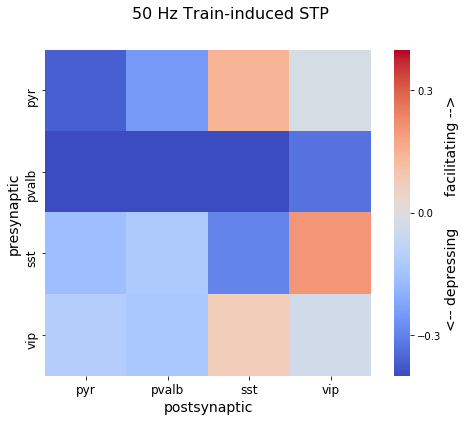

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '<-- depressing       facilitating -->'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

## Alternatively, we can calculate the average resting state variance for each pairing

In [12]:
var = df.pivot_table('variance', 'pre_class', 'post_class', aggfunc=np.mean)

# sort rows/cols into the expected order
order = list(cell_classes)
var = var[order].loc[order]

var

post_class,pyr,pvalb,sst,vip
pre_class,,,,
pyr,-0.309445,0.491906,1.781470,1.442159
pvalb,-0.768287,-0.962233,-0.715864,-0.356003
sst,-0.303308,-0.156712,0.038853,0.079488
vip,0.486764,0.653275,0.295944,0.464769


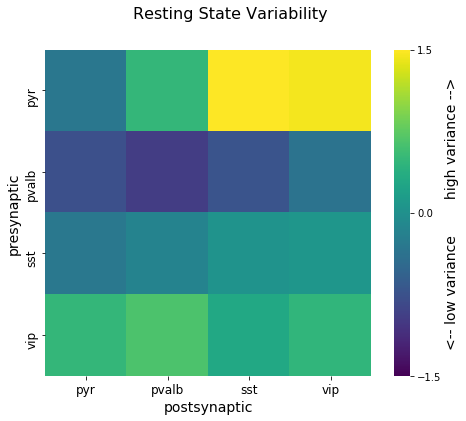

In [17]:
fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(var, cmap='viridis', vmin=-1.5, vmax=1.5, square=True, ax=ax,
                cbar_kws={"ticks":[-1.5, 0, 1.5], 'label': '<-- low variance        high variance -->'})

fig.suptitle("Resting State Variability", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

## 5. Extract multiple synaptic properties and plot as matrices

Plotting synaptic properties among cell sublcasses in matrices like these is common enough that we have provided a convenince function to do just that called `cell_class_matrix`

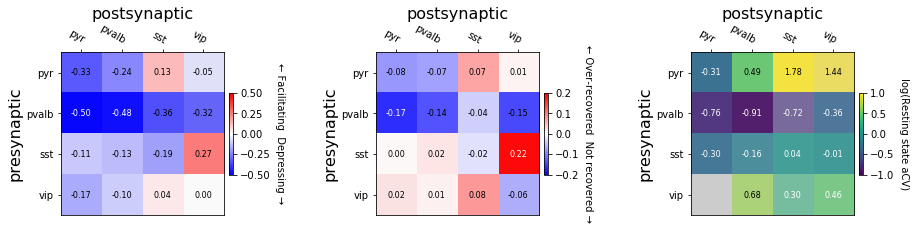

In [18]:
from aisynphys.ui.notebook import cell_class_matrix

fig,ax = plt.subplots(1, 3, figsize=(16, 3))

metrics = ['stp_induction_50hz', 'stp_recovery_250ms', 'variability_resting_state']

for i, metric in enumerate(metrics):
    cell_class_matrix(
        pre_classes=cell_classes, 
        post_classes=cell_classes,
        metric=metric, 
        class_labels=None, ax=ax[i],
        db=db, pair_query_args={
            'experiment_type': 'standard multipatch',
            'synapse': True,
            'species': 'mouse',
        }
    );